<a href="https://colab.research.google.com/github/DRO-Physics/DL-and-ML-for-Medical-Physics/blob/main/Survival_Modelling_Prelim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML for survival modelling in Breast Cancer Patient

## Conventional Statistical Methods using COX PH

In [ ]:
import os
import numpy as np 
import pandas as pd
from lifelines import CoxPHFitter, KaplanMeierFitter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [ ]:
## Read in data
fname = 'data_cleaned.xlsx'
df = pd.read_excel(fname)
df['Followup'] = df['Followup']+0.1
df.dropna(axis=0, inplace=True)
df.drop(['t4', 'n3', 'm1'], axis=1, inplace=True)

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2)
df_train.head(10)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7083 entries, 8400 to 6677
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   t0                          7083 non-null   float64
 1   t1                          7083 non-null   float64
 2   t2                          7083 non-null   float64
 3   t3                          7083 non-null   float64
 4   n0                          7083 non-null   float64
 5   n1                          7083 non-null   float64
 6   n2                          7083 non-null   float64
 7   m0                          7083 non-null   float64
 8   er_bool                     7083 non-null   int64  
 9   pr_bool                     7083 non-null   int64  
 10  her2_bool                   7083 non-null   float64
 11  Count_as_OS_bool            7083 non-null   int64  
 12  menopause_status_calc_bool  7083 non-null   float64
 13  Followup                    70

### Plot KM Curve

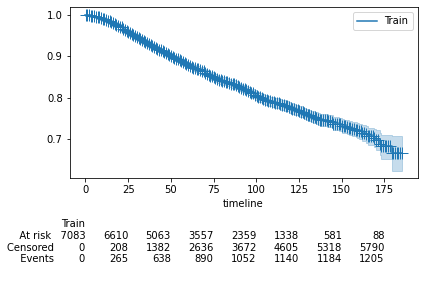

In [ ]:
kmf = KaplanMeierFitter()
kmf.fit(df_train['Followup'], df_train['Count_as_OS_bool'], label="Train")
kmf.plot_survival_function(show_censors=True, ci_show=True, at_risk_counts=True)
plt.tight_layout()

### Run Cox PH model

In [ ]:
cph = CoxPHFitter()
cph.fit(df_train, duration_col='Followup', event_col='Count_as_OS_bool')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7083 total observations, 5877 right-censored observations>
             duration col = 'Followup'
                event col = 'Count_as_OS_bool'
      baseline estimation = breslow
   number of observations = 7083
number of events observed = 1206
   partial log-likelihood = -9585.28
         time fit was run = 2021-01-15 02:29:09 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
t0                          -1.58       0.21       0.35            -2.27            -0.89                 0.10                 0.41
t1                          -1.15       0.32       0.11            -1.37            -0.92                 0.26                 0.40
t2                          -0.68       0.51       0.10            -0.88            -0.48                 0.42                 0.62
t3                          -0.26       0.77       0.12            -0.49            -0.02                 0.61                 0.98
n0                          -1.20       0.30       0.09            -1.38            -1.02                 0.25                 0.36
n1                          -0.80       0.45       0.09            -0.97            -0.62                 0.38                 0.54
n2                          -0.37       0.69       0.09            -0.55            -0.19                 0.58                 0.83
m0                          -1.48       0.23       0.10            -1.67            -1.28                 0.19                 0.28
er_bool                     -0.32       0.73       0.08            -0.48            -0.16                 0.62                 0.85
pr_bool                     -0.35       0.71       0.07            -0.49            -0.20                 0.61                 0.82
her2_bool                   -0.29       0.75       0.07            -0.43            -0.16                 0.65                 0.85
menopause_status_calc_bool   0.60       1.83       0.07             0.48             0.73                 1.61                 2.08

                                z      p   -log2(p)
covariate                                          
t0                          -4.51 <0.005      17.21
t1                         -10.15 <0.005      78.01
t2                          -6.75 <0.005      36.03
t3                          -2.13   0.03       4.90
n0                         -13.21 <0.005     129.94
n1                          -8.69 <0.005      57.95
n2                          -3.95 <0.005      13.66
m0                         -14.88 <0.005     163.89
er_bool                     -4.01 <0.005      14.03
pr_bool                     -4.65 <0.005      18.20
her2_bool                   -4.25 <0.005      15.49
menopause_status_calc_bool   9.25 <0.005      65.28
---
Concordance = 0.75
Partial AIC = 19194.56
log-likelihood ratio test = 993.36 on 12 df
-log2(p) of ll-ratio test = 678.67

<AxesSubplot:xlabel='log(HR) (95% CI)'>

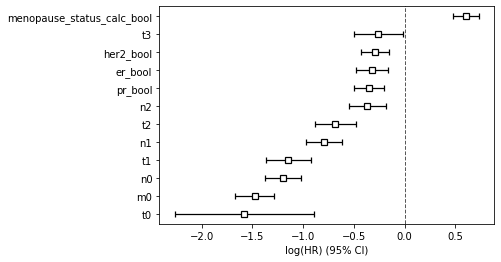

In [ ]:
## Plot Hazard Ratio
cph.plot()

In [ ]:
## Check Assumption
cph.check_assumptions(df_train)

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 7083 total observations, 5877 right-censored observations>
         test_name = proportional_hazard_test

---
                                 test_statistic      p  -log2(p)
er_bool                    km             41.18 <0.005     32.75
                           rank           40.22 <0.005     32.04
her2_bool                  km              4.63   0.03      4.99
                           rank            5.29   0.02      5.54
m0                         km              1.61   0.20      2.29
                           rank            1.01   0.32      1.67
menopause_status_calc_bool km              0.04   0.84      0.24
                           rank            0.16   0.69      0.55
n0                         km              0.32   0.57      0.81
                           rank            0.48   0.49      1.04
n1                         km              0.42   0.52      0.95
                           rank            0.97   0.33      1.62
n2                         km              1.40   0.24      2.08
                           rank            2.51   0.11      3.15
pr_bool                    km              7.14   0.01      7.05
                           rank            7.40   0.01      7.26
t0                         km              0.85   0.36      1.49
                           rank            1.60   0.21      2.28
t1                         km              2.06   0.15      2.73
                           rank            1.74   0.19      2.42
t2                         km              0.30   0.58      0.78
                           rank            0.17   0.68      0.56
t3                         km              1.08   0.30      1.75
                           rank            0.84   0.36      1.48



1. Variable 'er_bool' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['er_bool', ...]` in the call
in `.fit`. See documentation in link [E] below.

2. Variable 'pr_bool' failed the non-proportional test: p-value is 0.0065.

   Advice: with so few unique values (only 2), you can include `strata=['pr_bool', ...]` in the call
in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.re

[]

In [ ]:
cph.predict_survival_function(df_test)

,12170,68,6904,5847,10172,5773,1,10182,3537,4752,...,7016,3493,5971,5762,10008,12458,5315,1386,1347,11112
0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1.0,0.999956,0.999853,0.999968,0.999943,0.999899,0.999953,0.999968,0.999582,0.999869,0.999395,...,0.999319,0.999694,0.999925,0.999943,0.999897,0.999943,0.999877,0.999968,0.999912,0.999943
2.0,0.999737,0.999116,0.999805,0.999654,0.999392,0.999717,0.999805,0.997485,0.999208,0.996361,...,0.995901,0.998160,0.999549,0.999658,0.999381,0.999658,0.999258,0.999805,0.999469,0.999658
3.0,0.999561,0.998523,0.999674,0.999421,0.998983,0.999527,0.999674,0.995799,0.998677,0.993925,...,0.993159,0.996926,0.999247,0.999428,0.998966,0.999428,0.998760,0.999674,0.999113,0.999428
4.0,0.999295,0.997630,0.999477,0.999071,0.998369,0.999241,0.999477,0.993265,0.997878,0.990265,...,0.989040,0.995070,0.998791,0.999082,0.998340,0.999082,0.998011,0.999477,0.998577,0.999082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181.0,0.851088,0.581428,0.887432,0.808686,0.688612,0.840648,0.887432,0.213521,0.615402,0.106970,...,0.080621,0.323278,0.758569,0.810731,0.684167,0.810731,0.634428,0.887432,0.722252,0.810731
182.0,0.851088,0.581428,0.887432,0.808686,0.688612,0.840648,0.887432,0.213521,0.615402,0.106970,...,0.080621,0.323278,0.758569,0.810731,0.684167,0.810731,0.634428,0.887432,0.722252,0.810731
183.0,0.851088,0.581428,0.887432,0.808686,0.688612,0.840648,0.887432,0.213521,0.615402,0.106970,...,0.080621,0.323278,0.758569,0.810731,0.684167,0.810731,0.634428,0.887432,0.722252,0.810731
184.0,0.851088,0.581428,0.887432,0.808686,0.688612,0.840648,0.887432,0.213521,0.615402,0.106970,...,0.080621,0.323278,0.758569,0.810731,0.684167,0.810731,0.634428,0.887432,0.722252,0.810731


In [ ]:
print(cph.predict_median(df_test))

12170    inf
68       inf
6904     inf
5847     inf
10172    inf
        ... 
12458    inf
5315     inf
1386     inf
1347     inf
11112    inf
Name: 0.5, Length: 1771, dtype: float64


### Model Assessment

ICI =  0.009729096113483337
E50 =  0.004459681274743055


(<AxesSubplot:title={'center':'Smoothed calibration curve of \npredicted vs observed probabilities of t ≤ 60 mortality'}, xlabel='Predicted probability of \nt ≤ 60 mortality', ylabel='Observed probability of \nt ≤ 60 mortality'>,
 0.009729096113483337,
 0.004459681274743055)

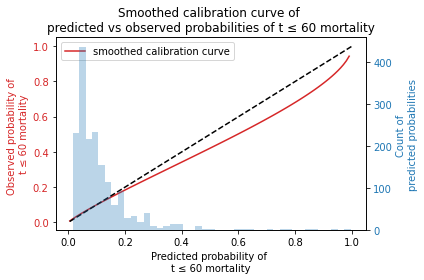

In [ ]:
from lifelines.calibration import survival_probability_calibration
survival_probability_calibration(cph, df_test, t0=60) # 5 Years survival OOD Calibration

ICI =  0.025286760637165312
E50 =  0.027978555144743122


(<AxesSubplot:title={'center':'Smoothed calibration curve of \npredicted vs observed probabilities of t ≤ 120 mortality'}, xlabel='Predicted probability of \nt ≤ 120 mortality', ylabel='Observed probability of \nt ≤ 120 mortality'>,
 0.025286760637165312,
 0.027978555144743122)

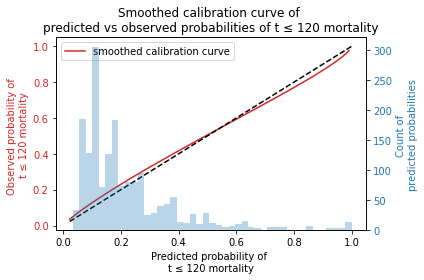

In [ ]:
survival_probability_calibration(cph, df_test, t0=120) # 10 Years survival OOd Calibration

In [ ]:
## Cross validation
from lifelines.utils import k_fold_cross_validation
cph_cv = CoxPHFitter()
scores = k_fold_cross_validation(cph_cv, df, duration_col='Followup', event_col='Count_as_OS_bool', k =10, scoring_method='concordance_index')
print(scores)
print(np.mean(scores), np.std(scores))

[0.714063679059343, 0.7064340020765649, 0.7670464812236264, 0.7588253857705617, 0.798329417366193, 0.7526644892346039, 0.722467825364945, 0.7212674148809961, 0.739978021978022, 0.7891769369205185]
0.7470253653875374 0.030051767646321562


## Using ML Survival Modelling

In [ ]:
from pysurvival.models.semi_parametric import CoxPHModel, NonLinearCoxPHModel
from pysurvival.models.multi_task import NeuralMultiTaskModel
from pysurvival.models.survival_forest import RandomSurvivalForestModel
from pysurvival.models.svm import KernelSVMModel
from pysurvival.utils.metrics import concordance_index, integrated_brier_score
# from pysurvival.utils.display import integrated_brier_score
from sklearn.model_selection import KFold
df_features = df.drop(['Count_as_OS_bool', 'Followup'], axis=1)

In [ ]:
def CoxModel(X_train, X_test, T_train, T_test, E_train, E_test): 
    coxph = CoxPHModel()
    coxph.fit(X_train, T_train, E_train, lr=0.3, l2_reg=1e-2, init_method='zeros', verbose=False)
    #### 5 - Cross Validation / Model Performances
    c_index = (concordance_index(coxph, X_test, T_test, E_test))
#     print('C-index: {:.2f}'.format(c_index))
    ibs = (integrated_brier_score(coxph, X_test, T_test, E_test, t_max=120))
#     print('IBS: {:.2f}'.format(ibs))
    return (c_index, ibs)

def DeepSurvModel(X_train, X_test, T_train, T_test, E_train, E_test): 
    structure = [ {'activation': 'BentIdentity', 'num_units': 150},  ]
    model = NonLinearCoxPHModel(structure=structure)
    model.fit(X_train, T_train, E_train, lr=1e-3, l2_reg=1e-2, init_method='xav_uniform', verbose=True)
    #### 5 - Cross Validation / Model Performances
    c_index = (concordance_index(model, X_test, T_test, E_test))
#     print('C-index: {:.2f}'.format(c_index))
    ibs = (integrated_brier_score(model, X_test, T_test, E_test, t_max=120))
#     print('IBS: {:.2f}'.format(ibs))
    return (c_index, ibs)

def NeuralMultiTaskSurvivalModel(X_train, X_test, T_train, T_test, E_train, E_test): 
    structure = [ {'activation': 'ReLU', 'num_units': 150},  ]
    model = NeuralMultiTaskModel(structure=structure, bins=150)
    model.fit(X_train, T_train, E_train, lr=1e-3, num_epochs = 500, init_method='orthogonal', optimizer = 'rprop')
    #### 5 - Cross Validation / Model Performances
    c_index = (concordance_index(model, X_test, T_test, E_test))
#     print('C-index: {:.2f}'.format(c_index))
    ibs = (integrated_brier_score(model, X_test, T_test, E_test, t_max=120))
#     print('IBS: {:.2f}'.format(ibs))
    return (c_index, ibs)

def KernelSVMSurvivalModel(X_train, X_test, T_train, T_test, E_train, E_test): 
    model = KernelSVMModel(kernel='Gaussian', scale=0.25)
    model.fit(X_train, T_train, E_train, init_method='orthogonal', with_bias = True, lr = 0.8,  tol = 1e-3,  l2_reg = 1e-4)
    #### 5 - Cross Validation / Model Performances
    c_index = (concordance_index(model, X_test, T_test, E_test))
#     print('C-index: {:.2f}'.format(c_index))
    ibs = (integrated_brier_score(model, X_test, T_test, E_test, t_max=120))
#     print('IBS: {:.2f}'.format(ibs))
    return (c_index, ibs)


In [ ]:
def RSFModel(X_train, X_test, T_train, T_test, E_train, E_test): 
    model = RandomSurvivalForestModel(num_trees=200)
    model.fit(X_train, T_train, E_train, max_features="sqrt", max_depth=5, min_node_size=20)
    #### 5 - Cross Validation / Model Performances
    c_index = (concordance_index(model, X_test, T_test, E_test))
#     print('C-index: {:.2f}'.format(c_index))
    ibs = (integrated_brier_score(model, X_test, T_test, E_test, t_max=120))
#     print('IBS: {:.2f}'.format(ibs))
    return (c_index, ibs)


In [ ]:
## Prepare datasets nd running pysurvival
kf = KFold(n_splits=5)
CoxModel_cindex = []
deepsurv_cindex = []
MTLR_cindex = []
SVM_cindex = []
RSF_cindex = []

for train_index, test_index in kf.split(df):
    X_train, X_test = df_features.to_numpy()[train_index], df_features.to_numpy()[test_index]
    T_train, T_test = df['Followup'].values[train_index], df['Followup'].values[test_index]
    E_train, E_test = df['Count_as_OS_bool'].values[train_index], df['Count_as_OS_bool'].values[test_index]
    c_index, ibs = NeuralMultiTaskSurvivalModel(X_train, X_test, T_train, T_test, E_train, E_test)
    MTLR_cindex.append(c_index)
    c_index, ibs = RSFModel(X_train, X_test, T_train, T_test, E_train, E_test)
    RSF_cindex.append(c_index)
    c_index, ibs = CoxModel(X_train, X_test, T_train, T_test, E_train, E_test)
    CoxModel_cindex.append(c_index)
    c_index, ibs = DeepSurvModel(X_train, X_test, T_train, T_test, E_train, E_test)
    deepsurv_cindex.append(c_index)

print('Cox Model C-index: %.3f (%.3f)' %(np.mean(CoxModel_cindex),np.std(CoxModel_cindex)))
print('DeepSurv Model C-index: %.3f (%.3f)' %(np.mean(deepsurv_cindex),np.std(deepsurv_cindex)))
print('MTLR Model C-index: %.3f (%.3f)' %(np.mean(MTLR_cindex),np.std(MTLR_cindex)))
print('SVM Model C-index: %.3f (%.3f)' %(np.mean(SVM_cindex),np.std(SVM_cindex)))
print('RSF Model C-index: %.3f (%.3f)' %(np.mean(RSF_cindex),np.std(RSF_cindex)))

% Completion: 100%|**********************************************|Loss: 7212.78
% Completion: 100%|**********************************************|Loss: 9650.87
% Completion: 100%|**********************************************|Loss: 7283.45
% Completion: 100%|**********************************************|Loss: 9715.39
% Completion: 100%|**********************************************|Loss: 7203.48
% Completion: 100%|**********************************************|Loss: 9671.40
% Completion: 100%|**********************************************|Loss: 7067.05
% Completion: 100%|**********************************************|Loss: 9373.46
% Completion: 100%|**********************************************|Loss: 7303.81
% Completion: 100%|**********************************************|Loss: 9826.66


Cox Model C-index: 0.672 (0.035)
DeepSurv Model C-index: 0.672 (0.037)
MTLR Model C-index: 0.668 (0.044)
SVM Model C-index: nan (nan)
RSF Model C-index: 0.667 (0.038)


/home/user/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/.local/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
